# Baseline Model for Crop Yield Estimation and Explaining the Relevant Factors for Model Decisions
The goal in this hackaton is to use the knowledge about explainable AI gathered in the ML4Earth xAI workshop to build machine learning model for yield prediction and to use explainable machine learning to identify the relevant factors and discover the impact of the extreme weather events for crop yield prediction [1]. Crop yield estimation is extremely important for ensuring food security in terms of the ever increasing extreme weather events [2]. Therefore, having an accurate model for yield prediction and at the same time being able to explain the relevant factors which drive the model inference is essential for designing efficient agricultural policies which can help to mitigate the food security challenges.

In this notebook, we provide an example of how to train a baseline random forest model and to use the SHAP method [3] to understand the driving factors for the model predictions.

First, we import the libraries necessary for bulding the random forest model and the explainability analysis.

In [326]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import json
import csv as csv
import sys
from osgeo import gdal,gdalconst
from osgeo import ogr

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import codecs
import shap
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Next, we define util functions which allow us to preprocess the crop yield dataset provided in [3]. The central function is the **load_features_and_yield** function which reads the county features, and the corresponding groundtruth yield values.

In [327]:
ROOT_DATA_DIR = "/Users/siruiwang/ML4Earth-Hackathon-2022-main/dataset/composite_npy/image_nyp/corn"
SHPFILE = "/Users/siruiwang/ML4Earth-Hackathon-2022-main/dataset/composite_npy/Geometry/tl_2018_us_counties.shp"
COUNTY_FEATURE_NAMES = ["RED", "NIR", "BLUE", "GREEN", "NIR2", "SWIR1", "SWIR2", "TEMP_MIN", "TEMP_MAX", "PRCP", "HEATWAVE INDEX", "DROUGHT INDEX", "NDVI", "EVI", "NDWI"]
NUM_FEATURES_PER_DATE = len(COUNTY_FEATURE_NAMES)

# "year" should be the integer year number (2000-2021)
# The function will return a list of required dates
def get_observation_acquisition_dates(year):
    # read a certain column before the 46th row
    df = pd.read_excel(io=os.path.join(ROOT_DATA_DIR, 'MODIS dates.xlsx'), usecols=[year - 2000], nrows=46)
    dates = df[year].values.tolist()
    return dates

def get_feature_names(dates):
    feature_names = []
    for date in dates:
        for county_feature in COUNTY_FEATURE_NAMES:
            feature_name = '{}_{}'.format(date, county_feature)
            feature_names.append(feature_name)
    
    return feature_names

def load_features_and_yield(target_year):
    #read the crop yield values from the json file
    with open(os.path.join(ROOT_DATA_DIR, 'labels.json')) as f:
        #f=codecs.encode('utf-8-sig')
        #f.encoding='utf-8-sig'
        crop_yield_per_county = json.load(f)#csv.reader(f)
  
    counties_features = []
    counties_yield = []
    
 

    for county_features_file in os.listdir(ROOT_DATA_DIR):
      if county_features_file.startswith(str(target_year)):
            county_id = county_features_file.split('.')[0].split('_')[1]
            county_id_key = '{}_{}'.format(county_id, target_year)
            if county_id_key in crop_yield_per_county:
                county_yield = float(crop_yield_per_county[county_id_key])
                counties_yield.append(county_yield)
                county_features_file_path = os.path.join(ROOT_DATA_DIR, county_features_file)
                county_features = np.load(county_features_file_path)
                counties_features.append(county_features.flatten())
    print (np.array(counties_features).shape)
    
    
    #scale all features in range [0, 1]
    counties_features = np.array(counties_features)
    scaler = MinMaxScaler()
    scaler.fit(counties_features)
    counties_features = scaler.transform(counties_features)
    
    #convert the features to pandas dataframe
    observation_acquisition_dates = get_observation_acquisition_dates(target_year)
    feature_names = get_feature_names(observation_acquisition_dates)
    counties_features = pd.DataFrame(counties_features, columns = feature_names)
    
    counties_yield = np.array(counties_yield)
    return counties_features, counties_yield

def get_abs_feature_importance_over_time(feature_suffix, shap_values, feature_names):
    feature_indices = np.array([feature_names.index(feature) for feature in feature_names if feature.endswith(feature_suffix)])
    feature_dates = [feature_names[idx].split('_')[0] for idx in feature_indices]
    feature_importance_over_time = np.take(shap_values.values, feature_indices, 1)
    
    feature_importance_over_time = pd.DataFrame(np.abs(feature_importance_over_time), columns=feature_dates)
    feature_importance_over_time = pd.melt(feature_importance_over_time, var_name="Date", value_name="SHAP feature importance")
    feature_importance_over_time["Feature"] = feature_suffix
    feature_importance_over_time['Date'] =  pd.to_datetime(feature_importance_over_time['Date'], format='%Y%m%d')
    return feature_importance_over_time

def get_abs_features_importances_over_time(shap_values, feature_names):
    all_features_importances_over_time = []
    
    for feature_suffix in COUNTY_FEATURE_NAMES:
        all_features_importances_over_time.append(get_abs_feature_importance_over_time(feature_suffix, shap_values, feature_names))
    
    return pd.concat(all_features_importances_over_time)
   

## Loading the features and the crop yield dataset for 2021
In our example, we train and predict the yield for 2021 for counties of the corn crop type. We load the dataset for 2021 by utilizing the above-defined **load_features_and_yield** function.

In [328]:
#load the dataset
counties_features, counties_yield = load_features_and_yield(2021)
feature_names = counties_features.columns.values.tolist()

(359, 690)


## Random Forest Model Training
For training the random forest model, we randomly split the counties to 80% in the training set and 20% in the test set. Afterwards, we use the implementation from the scikit-learn library to train a regression random forest model for yield prediction and we output the score of our model on the test set.

In [329]:
#train and test the random forest model based on the data acquired in 2021
counties_features_train, counties_features_test, counties_yield_train, counties_yield_test = train_test_split(counties_features, counties_yield, test_size=0.2, random_state=42)
random_forest_regressor = RandomForestRegressor(n_estimators=50)
random_forest_regressor.fit(counties_features_train, counties_yield_train)

# Random forest regressor needs a vector as input
_shape = counties_features_train.shape
X_train = np.reshape(counties_features_train, (_shape[0], _shape[1]))
print("X train shape:", X_train.shape)

n_test = counties_features_test.shape[0]
X_test = np.reshape(counties_features_test, (n_test, _shape[1] ))
print("X test shape:", X_test.shape)



X train shape: (287, 690)
X test shape: (72, 690)


In [330]:
counties_yield_pred_rf = random_forest_regressor.predict(counties_features_test)
#r2_score = random_forest_regressor.score(counties_yield_test, counties_yield_pred_rf)
#print("R^2 score in the test set is %0.2f" % (r2_score))

mae_base = mean_absolute_error(counties_yield_test, counties_yield_pred_rf)
rmse_base = mean_squared_error(counties_yield_test, counties_yield_pred_rf, squared=False) # squared=True -> MSE, squared=False -> RMSE
#r2_base = r2_score(counties_yield_test, counties_yield_pred_rf)

def R2 (y_test, y_pre):
    sstot = np.sum((y_test-np.mean(y_test))**2)
    ssres = np.sum((y_test-y_pre)**2)
    r2=ssres/sstot
    return r2
r2_base = R2(counties_yield_test, counties_yield_pred_rf)
print("MAE:", mae_base) # Best possible is 0
print("RMSE:", rmse_base) # Best possible is 0
print("R2:", r2_base) # Best possible is 1

MAE: 8.343277777777773
RMSE: 10.754694845611477
R2: 0.16858925665993243


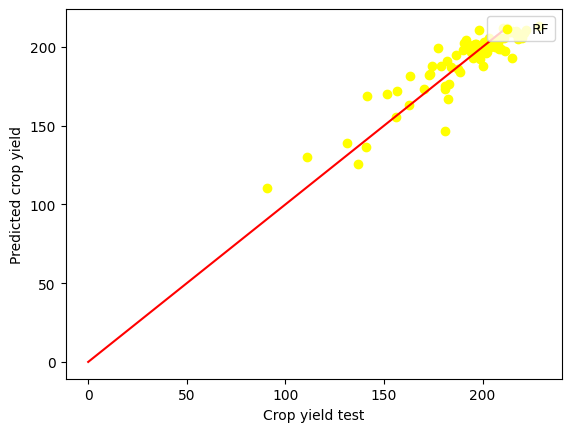

In [331]:
lim = int(np.min( [np.max(counties_yield_test), np.max(counties_yield_pred_rf)]))

plt.scatter(counties_yield_test, counties_yield_pred_rf, label="RF", color="yellow")
plt.legend(loc="upper right")
plt.xlabel("Crop yield test")
plt.ylabel("Predicted crop yield")
plt.plot( [0, lim], [0, lim], color="red")
plt.show()

To estimate the feature importance of different input variables for the trained random forest model, we use the SHAP implementation provided in the SHAP library [5]. The feature importances are computed by first initializing the **TreeExplainer** class with the trained random and afterwards the **explainer** method is called with the feature representation of the test set which returns the SHAP feature importances for every feature and data point in the test set. The below figure shows the absolute average contribution of each variable in a time point to the difference between the model prediction and the average of the predictions of the random forest model.

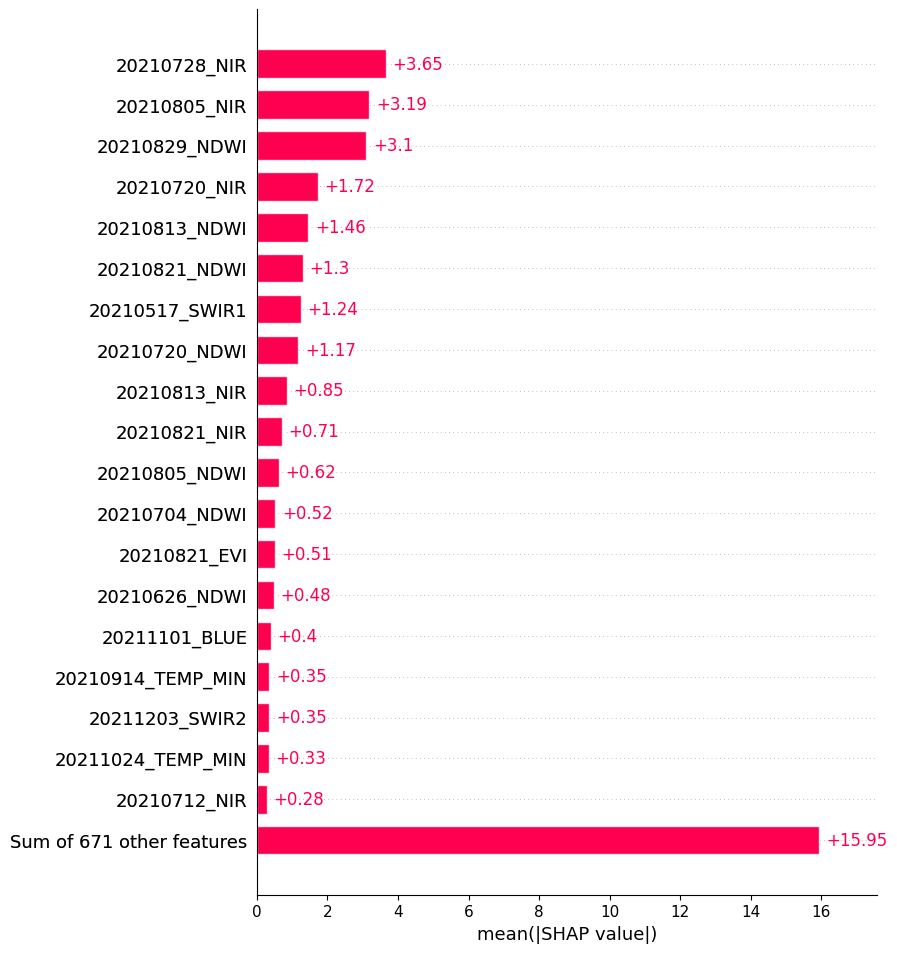

In [332]:
explainer = shap.TreeExplainer(random_forest_regressor)
shap_values = explainer(counties_features_test)
shap.plots.bar(shap_values, max_display=20)

Although the default barplot visualization from the SHAP library gives us indication the NIR band and the EWI derived feature have high importance in August, it still doesn't allow for clear visualization and interpretation of the variable and temporal importance of the trained model. Therefore, in the next step, we implement and use the **get_abs_features_importances_over_time** function which summarizes the importance for every feature and date into a single dataframe. Next, we use this dataframe to plot the evolvement of the SHAP values over time for every of the 15 input features to the model.



The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.



The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.



The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.



The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.



The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.



The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.



The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.



The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.



The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.



The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.



The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.



The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.



The `ci` parameter is deprecated. Use `errorbar='sd'` for the 

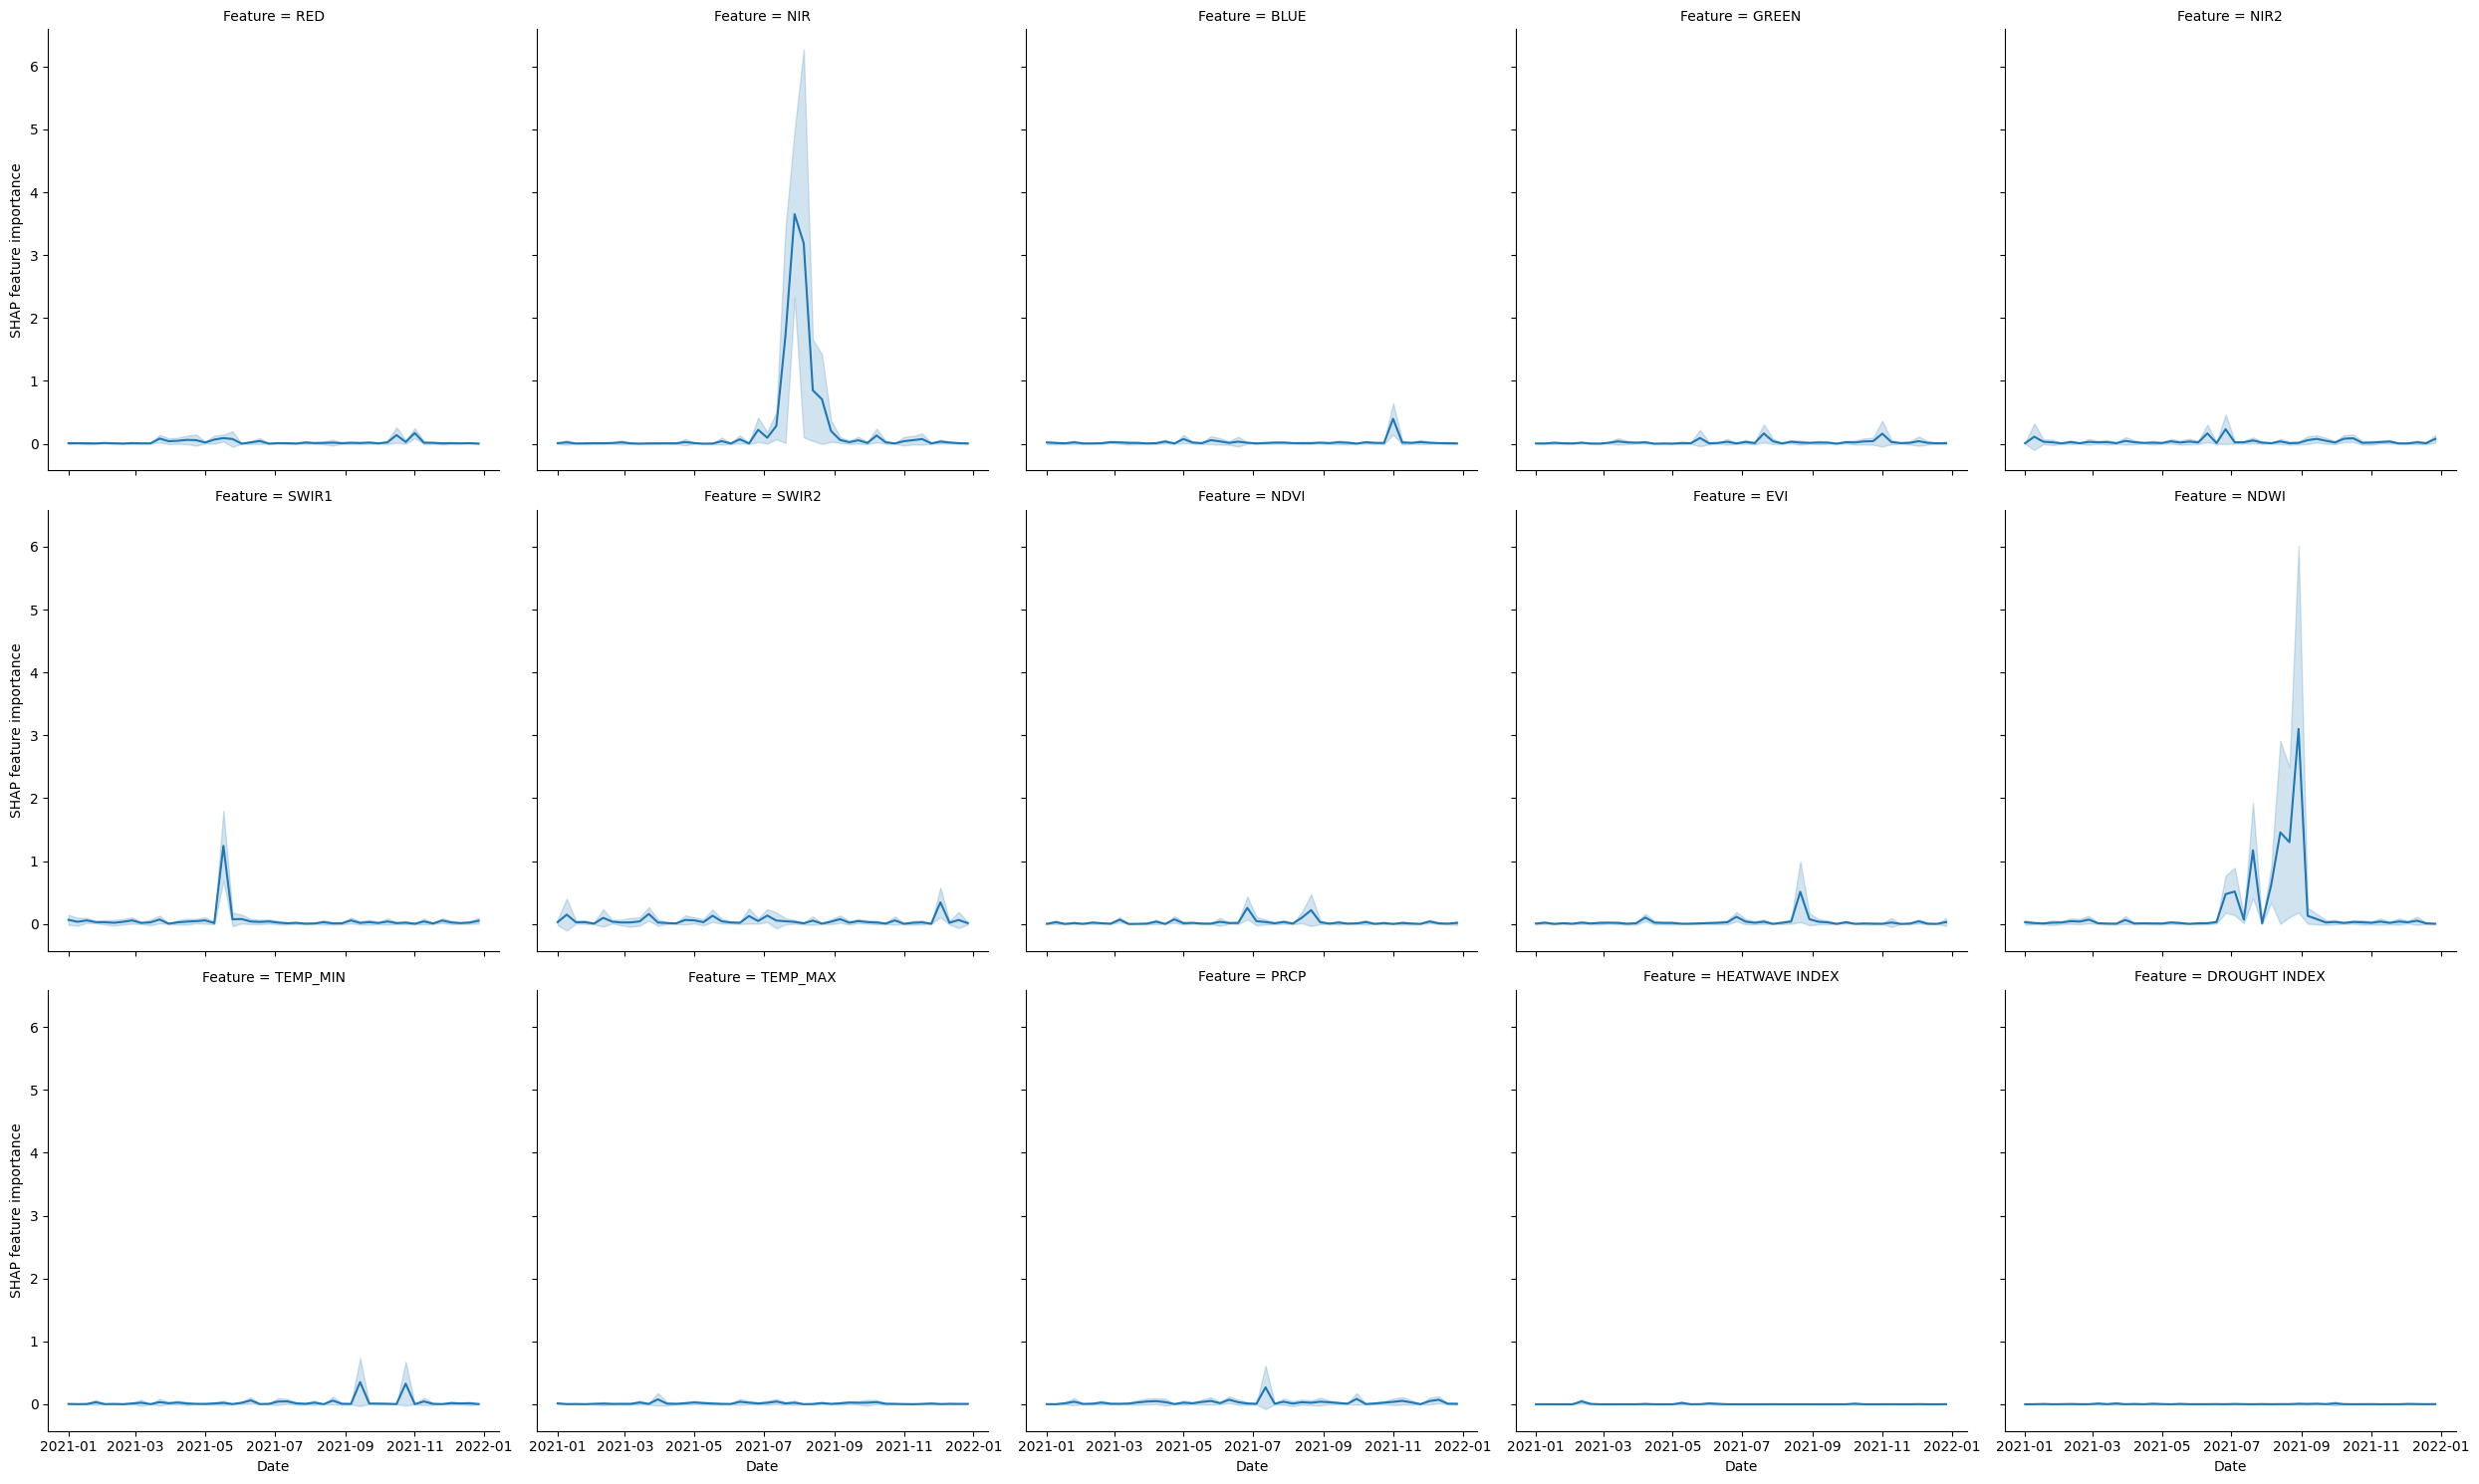

In [333]:
abs_features_importances_over_time = get_abs_features_importances_over_time(shap_values, feature_names)
g = sns.relplot(
    data=abs_features_importances_over_time,
    x="Date", y="SHAP feature importance",
    col="Feature",kind="line",
    ci="sd", col_order=["RED", "NIR", "BLUE", "GREEN", "NIR2", "SWIR1", "SWIR2", "NDVI", "EVI", "NDWI", "TEMP_MIN", "TEMP_MAX", "PRCP", "HEATWAVE INDEX", "DROUGHT INDEX"],
    col_wrap=5, height=5, aspect=1)

The plot above shows us that in terms of variable importance, the factors that most significantly impact the yield prediction are the NIR infrared and the NDWI index. The weather related variables have SHAP feature importances close to zero except for the precipitation. Additionally, these plot indicates that the heatwawe and drought index variable do not influence the model decisions.
On the other hand, in terms of temporal importance, the observations in the late vegetation season (end of summer) are valuable to the model. The exception is the precipitation variable whose relevant observations occur near July.

This notebook presented a simple framework which trains a baseline random forest model for crop yield prediction and uses the SHAP method to understand the relevant factors for the model inference. In this hackaton, we are looking forward to the application and development of more novel machine learning and deep learning methods for yield prediction as well as to xAI approaches that extract more useful insights for the inner workings of the model that could be of use to the different stakeholders. A possible starting directions could be the following:
- The impact of the extreme weather events on yield prediction.
- Counterfactual explanations. Example: Would the yield have been bigger if the temperature was lower.
- Early yield prediction: Development of methods that can accurately predict the yield by using only the observations acquired in early vegetation season. Additionally, in order to take preventive measures, it would be interesting to understand which factor impact the low/high yield to be discovered early in the season.
- The presented approach used single year for training and testing the model. A more realistic scenario and an interesting research direction to explore would be to evaluate the model performance on future years when it is trained on the past years.

## Artificial neural network

The human brain is a *machine* capable of performing very complex tasks, such as pattern recognition, motor control of a limb or perception of sensory stimuli, much faster than any machine invented by man. For this reason, great efforts have been (and continue to be) made to understand how they work. 

This machine is made up of about 100 trillion neurons (cells of the nervous system specialized in the reception and conduction of stimuli), which communicate with each other, forming complex circuits, which are capable of carrying out brain function. This biological model was the inspiration for McCulloch and Pitts to propose a [new computer model](https://www.cs.cmu.edu/~./epxing/Class/10715/reading/McCulloch.and.Pitts.pdf) in 1943: the *artificial neural network* (ANN).

An ANN is a network of computer units (neurons) connected to each other, where each unit performs a calculation from an input and communicates its result (output) to the connected units. Typically, the connections are weighted, which indicates how strong the connection between two units is. Also, the calculation units are usually grouped into modules or layers. ANNs have properties and capabilities that are very useful for solving complex problems, highlighting its nonlinearity, adaptability, fault tolerance, among others. Thanks to these properties it has been possible to overcome the results obtained in multiple problems.



> Deep-learning methods are representation-learning methods with multiple levels of representation, obtained by composing simple but non-linear modules that each transform the representation at one level (starting with the raw input) into a representation at a higher, slightly more abstract level. With the composition of enough such transformations, very complex functions can be learned. *Yann LeCun, Yoshua Bengio and Geoffrey Hinton, 2015*

In [334]:
simple_nn = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(_shape[1],1)),
  tf.keras.layers.Dense(256, activation='relu'), 
  tf.keras.layers.Dense(128, activation='relu'),  
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(1, activation='relu'),
])

simple_nn.compile(optimizer='adam',
              loss='mean_absolute_error')

In [335]:

simple_nn.fit(counties_features_train, counties_yield_train, epochs=32)

Epoch 1/32


2022-11-27 05:25:52.938585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 1s 14ms/step - loss: 180.5387
Epoch 2/32
9/9 [==============================] - 0s 8ms/step - loss: 130.5934
Epoch 3/32
9/9 [==============================] - 0s 8ms/step - loss: 43.6395
Epoch 4/32
9/9 [==============================] - 0s 8ms/step - loss: 27.8675
Epoch 5/32
9/9 [==============================] - 0s 9ms/step - loss: 25.3486
Epoch 6/32
9/9 [==============================] - 0s 9ms/step - loss: 20.3106
Epoch 7/32
9/9 [==============================] - 0s 9ms/step - loss: 17.9709
Epoch 8/32
9/9 [==============================] - 0s 8ms/step - loss: 15.6544
Epoch 9/32
9/9 [==============================] - 0s 7ms/step - loss: 16.1967
Epoch 10/32
9/9 [==============================] - 0s 8ms/step - loss: 13.5836
Epoch 11/32
9/9 [==============================] - 0s 8ms/step - loss: 12.5707
Epoch 12/32
9/9 [==============================] - 0s 8ms/step - loss: 12.0252
Epoch 13/32
9/9 [==============================] - 0s 7ms/step - loss

In [336]:
counties_yield_pred_nn = simple_nn.predict(counties_features_test)

3/3 [==============================] - 0s 13ms/step


2022-11-27 05:25:58.251479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [337]:
mae_nn = mean_absolute_error(counties_yield_test, counties_yield_pred_nn)
rmse_nn = mean_squared_error(counties_yield_test, counties_yield_pred_nn, squared=False) # squared=True -> MSE, squared=False -> RMSE
r2_nn = R2(counties_yield_test, counties_yield_pred_nn)

print("MAE:", mae_nn) # Best possible is 0
print("RMSE:", rmse_nn) # Best possible is 0
print("R2:", r2_nn) # Best possible is 1

MAE: 9.404314867655437
RMSE: 11.459828414730717
R2: 123.46655685536675


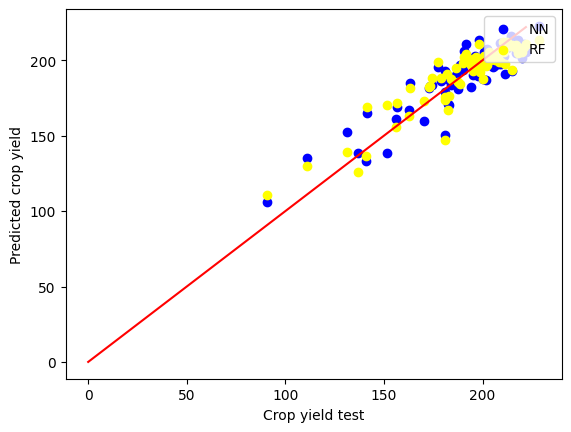

In [338]:
lim = int(np.max( [lim, np.max(counties_yield_pred_nn)]))

plt.scatter(counties_yield_test, counties_yield_pred_nn, label="NN", color="blue")
plt.scatter(counties_yield_test, counties_yield_pred_rf, label="RF", color="yellow")
plt.legend(loc="upper right")
plt.xlabel("Crop yield test")
plt.ylabel("Predicted crop yield")
plt.plot( [0, lim], [0, lim], color="red")
plt.show()

Epoch 1/32
1/9 [==>...........................] - ETA: 2s - loss: 192.6418

2022-11-27 05:26:08.366543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 0s 12ms/step - loss: 188.0446
Epoch 2/32
9/9 [==============================] - 0s 9ms/step - loss: 187.7466
Epoch 3/32
9/9 [==============================] - 0s 7ms/step - loss: 187.6964
Epoch 4/32
9/9 [==============================] - 0s 9ms/step - loss: 187.6830
Epoch 5/32
9/9 [==============================] - 0s 14ms/step - loss: 187.6775
Epoch 6/32
9/9 [==============================] - 0s 10ms/step - loss: 187.6747
Epoch 7/32
9/9 [==============================] - 0s 9ms/step - loss: 187.6729
Epoch 8/32
9/9 [==============================] - 0s 11ms/step - loss: 187.6716
Epoch 9/32
9/9 [==============================] - 0s 8ms/step - loss: 187.6706
Epoch 10/32
9/9 [==============================] - 0s 8ms/step - loss: 187.6698
Epoch 11/32
9/9 [==============================] - 0s 8ms/step - loss: 187.6691
Epoch 12/32
9/9 [==============================] - 0s 8ms/step - loss: 187.6685
Epoch 13/32
9/9 [==============================] - 0s 7m

2022-11-27 05:26:11.120794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


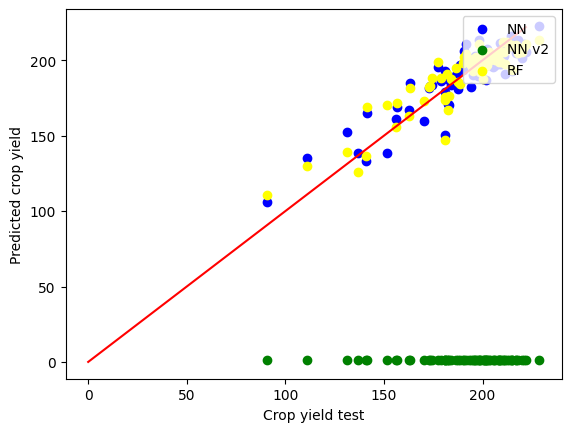

In [339]:
simple_nn_v2 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(_shape[1], 1)),
  tf.keras.layers.Dense(256, activation='sigmoid'),  
  tf.keras.layers.Dense(128, activation='sigmoid'),  
  tf.keras.layers.Dense(64, activation='sigmoid'),
  tf.keras.layers.Dense(1, activation='sigmoid'),
])

simple_nn_v2.compile(optimizer='adam',
              loss='mean_absolute_error')
#counties_features_train, counties_features_test, counties_yield_train, counties_yield_test = train_test_split(counties_features, counties_yield, test_size=0.2, random_state=42)
simple_nn_v2.fit(counties_features_train, counties_yield_train, epochs=32)



counties_yield_pred_nn_v2 = simple_nn_v2.predict(counties_features_test)


mae_nn_v2 = mean_absolute_error(counties_yield_test, counties_yield_pred_nn_v2)
rmse_nn_v2 = mean_squared_error(counties_yield_test, counties_yield_pred_nn_v2, squared=False) # squared=True -> MSE, squared=False -> RMSE
r2_nn_v2 = R2(counties_yield_test, counties_yield_pred_nn_v2)

print("MAE:", mae_nn_v2) # Best possible is 0
print("RMSE:", rmse_nn_v2) # Best possible is 0
print("R2:", r2_nn_v2) # Best possible is 1

lim = int(np.max( [lim, np.max(counties_yield_pred_nn_v2)]))

plt.scatter(counties_yield_test, counties_yield_pred_nn, label="NN", color="blue")
plt.scatter(counties_yield_test, counties_yield_pred_nn_v2, label="NN v2", color="green")
plt.scatter(counties_yield_test, counties_yield_pred_rf, label="RF", color="yellow")
plt.legend(loc="upper right")
plt.xlabel("Crop yield test")
plt.ylabel("Predicted crop yield")
plt.plot( [0, lim], [0, lim], color="red")
plt.show()

In [340]:
#Visulize prediction of yield
shp = ogr.Open(SHPFILE,0)
layer = shp.GetLayerByIndex(0)
for feature in layer:
    keys = feature.keys()
    for key in keys:
        value = feature.GetField(key)
    geometry = feature.geometry()
    #print(geometry)






In [341]:
#write results into csv file
n_test = counties_yield_test.shape[0]
X_test1 = np.reshape(counties_yield_pred_nn, (1,n_test))
x_test2=X_test1[0,:]
print(counties_yield_test,counties_yield_pred_rf,x_test2)
dataframe = pd.DataFrame({'counties_yield_test':counties_yield_test,'counties_yield_pred_rf':counties_yield_pred_rf,'counties_yield_pred_nn':x_test2})
dataframe.to_csv("result2021.csv",index = False, sep = ',')

[205.9 208.3 228.7 162.9 217.9 177.2 170.3 200.9 221.1 156.7 181.2 217.2
 221.8 215.1 201.4 211.6 201.5 191.7 186.8  90.8 181.2 163.  195.8 173.
 198.8 210.8 205.3 209.5 213.3 217.2 206.5 141.4 197.8 212.2 196.5 209.1
 193.2 220.2 111.1 182.8 203.9 188.4 173.3 190.6 198.6 180.8 187.7 214.3
 194.4 184.  182.3 207.8 208.5 196.2 210.3 140.9 155.9 202.3 202.  203.3
 215.  195.3 200.4 181.9 198.1 179.  136.7 151.5 174.4 190.2 131.3 202.5] [203.712 198.828 213.372 163.116 204.888 199.112 173.134 202.884 208.97
 171.804 146.842 209.898 211.092 210.152 202.764 197.574 200.61  204.33
 194.69  110.456 175.474 181.368 196.854 182.376 196.366 205.72  203.516
 198.586 209.424 207.934 200.07  169.096 197.074 212.094 201.892 205.89
 201.176 205.592 129.816 176.302 200.12  184.096 182.85  202.436 192.178
 173.422 185.808 209.278 197.018 187.306 167.078 202.302 205.46  201.756
 211.95  136.634 155.584 197.096 196.004 205.652 193.242 192.812 187.802
 191.124 210.76  188.112 125.876 170.252 188.11  198.0

# References:
[1] https://ml4earth.devpost.com/ <br>
[2] Wolanin, Aleksandra, et al. "Estimating and understanding crop yields with explainable deep learning in the Indian Wheat Belt." Environmental research letters 15.2 (2020): 024019. <br>
[3] Lundberg, Scott M., and Su-In Lee. "A unified approach to interpreting model predictions." Advances in neural information processing systems 30 (2017). <br>
[4] https://syncandshare.lrz.de/getlink/fiUh1RofUeMbugsSGD19QX/ <br>
[5] https://shap.readthedocs.io/en/latest/index.html <br>